# Poission Noise for low number statistics

This notebooks shows how to deal with assymetric poission noise at low number statistics. Generally poission errors are $\sqrt N$, where N is the total number of observations. However, it is to be noted that this is true for large N!. For small N (<100 counts), the poission distribution is skewed and assymetric, thus the possion noise will be assymetric in nature. We explore and caculate the assymetric noise here using percentile statsitics.

In [1]:
#import required libraries
import numpy as np 
from scipy.stats import poisson
import matplotlib.pyplot as plt

### Plot the poission distribution for small $\lambda$ or N
The plot below shows the Poission distribution for low number statistics

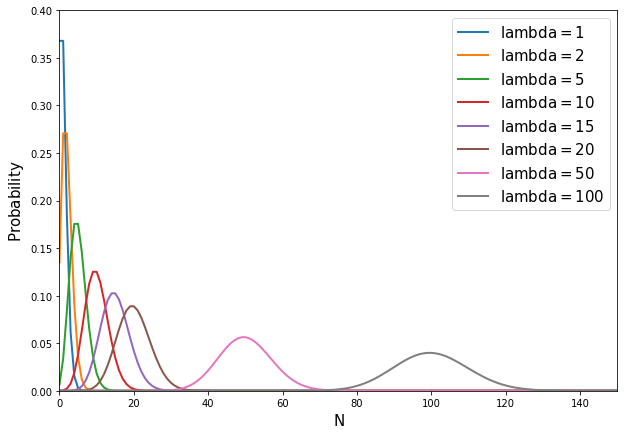

In [2]:
#define the array for which we will plot the distribution
l = [1,2,5,10,15,20,50,100]           # lambda = N

n = np.arange(0,151)                  # N-grid for calculation of Poisson distribution
ps = [poisson(i) for i in l]          # Poisson distributions using scipy
prob = [i.pmf(n) for i in ps]         # calculate pmf for our set

# Plot the distributions 
f, ax = plt.subplots(figsize=(10,7))
for i in range(len(l)):
    ax.plot(n,prob[i],label='$\mathrm{lambda=}$'+str(l[i]),lw=2.0)
    
ax.set_xlabel('$\mathrm{N}$',fontsize=15)
ax.set_ylabel('$\mathrm{Probability}$',fontsize=15)

ax.set_xlim(0,n[-1])
ax.set_ylim(0,0.4)
plt.legend(loc=1,prop={'size':15})

plt.show()

#calculate the mean
mean = [np.sum(i*n) for i in prob]

It is to note that all PDFs are normalised to unity and the mean of PDF is equal to the $\lambda$, that is a property of the poission distribution.

From the plot above we can see the asymetries of the distribution for low $\lambda$

$$Var(Poission distribution) = (X^2)_{mean}- (X_{mean})^2 = \lambda$$
$$\implies STD = \sqrt\lambda$$

This quantity does not reflect the skewness of distribution at small lambda, but simply provides a measure of scatter around its mean. Here, var is the variance and STD is the standard deviation

If we want our error of $\lambda=N$ to include asymmetry of Poisson distribution, we need to use some other statistics, such as percentiles. For Gaussian distribution, there is a probability of ~0.683 to find X within 1 sigma from its mean value, more details (here)[https://en.wikipedia.org/wiki/Percentile].

In other words, ~34.1% of the population lays within 1-sigma region to the right and to the left from the mean. We can calulate such 34.1-% percentiles for Poisson distribution: for large lambda, they will become symmetric with respect to the mean and will be equal to $STD = \sqrt\lambda$. For small lambda, the left and right 34.1-% percentiles will be different, which can be a measure of the Poisson distribution skewness. 

In brief, instead of calculating the error as $N\pm\sqrt{N}$, we calculate $N + 34.1\%-percentile-right - 34.1\%-percentile-left$   

    N       N_right     N_left      STD     (N_right-N_left)/N_mean (N_mean-STD)/STD 

   1          1.43       1.12       1.0              0.243              0.2724     

   2          1.78       1.34       1.41             0.282              0.1029     

   5          2.54       2.05       2.24             0.211              0.0273     

   10         3.46       2.95       3.16             0.158              0.0137     

   15         4.19       3.63       3.87             0.142              0.0099     

   20         4.78       4.23       4.47             0.121              0.0077     

   50         7.36       6.82       7.07             0.076              0.002      

   100        10.28      9.73       10.0             0.055              0.0003     



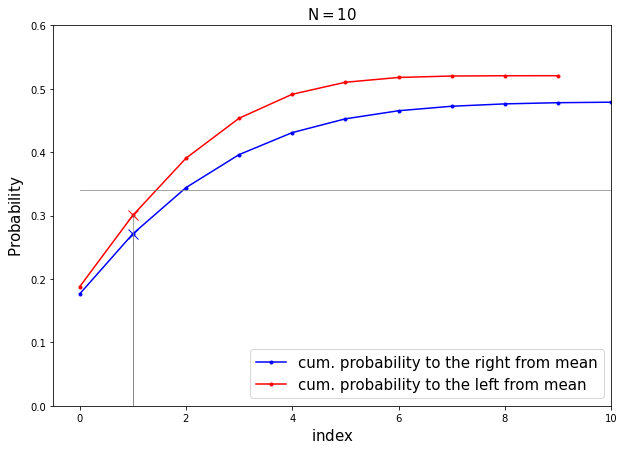

In [3]:
# Poisson noise
std = np.sqrt(l)

percentile = 0.341


print('{:^10}'.format('N'),'{:^10}'.format('N_right'),'{:^10}'.format('N_left'),'{:^10}'.format('STD'),
      '{:^14}'.format('(N_right-N_left)/N_mean'),'{:^16}'.format('(N_mean-STD)/STD'),'\n')


f, ax = plt.subplots(figsize=(10,7))


for i in range(len(l)): 
     
    # find indices showing location of the mean values (which also correspond to max probability):
    ind_max= np.where(n==round(mean[i],0))[0][0]
    
    # We split it along the center of the bin which coresponds to the maximum
    # For each part we calculate a cumulative probability (counting from the maximum, 
    # with the maximum bin divided between the two parts):
    
    psum_right = 0.5*prob[i][ind_max] + np.cumsum(prob[i][ind_max+1:])     # +1 means that we don't sum the max bin again
    psum_left = 0.5*prob[i][ind_max] + np.cumsum(prob[i][:ind_max][::-1])  # here +1 is not needed because array[:ind] goes up to ind-1 element
    
    # And find indices of the psum arrays which approximately correspond to 34.1-% percentiles.
    # It may happen that already the first element of psum array is larger than percentile 
    # (there is a correction later): 
    corr_left, corr_right = 0, 0 
    try:
        ind_percentile_right = np.where(psum_right-percentile<0)[0][-1] 
    except:
        ind_percentile_right = 0 
        corr_right = 1 
    try:
        ind_percentile_left = np.where(psum_left-percentile<0)[0][-1]  
    except:
        ind_percentile_left = 0 
        corr_left = 1 
    
    # Calculate percentiles themselves (at first, approximately). 
    # 0.5 means that a half of the max bin is added, 
    # +1 is needed to convert indices counts (0-th index of psum means that there is +1 count with respect 
    # to max bin). Note that this conversion between indices and counts corresponds to N-grid n with a step of 1.
    # If you use a larger grid step (though don't know why), use  0.5 + (ind_percentile + 1)*n_step.
    
    n_right = 0.5 + ind_percentile_right + 1 
    n_left = 0.5 + ind_percentile_left + 1
    
    # As Poisson distribution is discrete, probability cannot be calculated for fractions of N. 
    # So the cumulative probability arrays don't contain the exact value of percentile. 
    # We add a small correction to convert the obtained errors to exact 34.1-% percentiles
    # These corrections can be also negative 
    
    if corr_right==0:
        f_right = (percentile - psum_right[ind_percentile_right])/\
                  (psum_right[ind_percentile_right+1] - psum_right[ind_percentile_right])
    else:
        f_right = (percentile - psum_right[ind_percentile_right])/psum_right[ind_percentile_right]
    n_right = n_right + f_right
    
    if corr_left==0:
        f_left = (percentile - psum_left[ind_percentile_left])/\
                 (psum_left[ind_percentile_left+1] - psum_left[ind_percentile_left])
    else:
        f_left = (percentile - psum_left[ind_percentile_left])/psum_left[ind_percentile_left]
    n_left = n_left + f_left
    
    
    # Results. 
    
    print('{:<2}'.format(''),'{:<10}'.format(l[i]),
          '{:<10}'.format(round(float(n_right),2)),
          '{:<10}'.format(round(float(n_left),2)),
          '{:<16}'.format(round(std[i],2)),
          '{:<18}'.format(round((n_right-n_left)/np.mean([n_right,n_left]),3)),
          '{:<10}'.format(round((np.mean([n_right,n_left])-std[i])/std[i],4)),'\n')
    
    if i==3:
        ax.plot(psum_right,c='b',marker='o',markersize=3,label='cum. probability to the right from mean')
        ax.plot(psum_left,c='r',marker='o',markersize=3,label='cum. probability to the left from mean')
        ax.plot(ind_percentile_right,psum_right[ind_percentile_right],marker='x',markersize=10,c='b')
        ax.plot(ind_percentile_left,psum_left[ind_percentile_left],marker='x',markersize=10,c='r')
        ax.plot([ind_percentile_right,ind_percentile_right],[0,psum_right[ind_percentile_right]],c='grey',lw=0.7)
        ax.plot([ind_percentile_left,ind_percentile_left],[0,psum_left[ind_percentile_left]],c='grey',lw=0.7)
        ax.set_title('$\mathrm{N = }$'+str(l[i]),fontsize=15)
        ax.plot([0,10],[percentile,percentile],c='grey',lw=0.7)
        ax.set_xlim(-0.5,10)
        ax.set_ylim(0,0.6)
        ax.set_ylabel('$\mathrm{Probability}$',fontsize=15)
        ax.set_xlabel('$\mathrm{index}$',fontsize=15)
        plt.legend(loc=4,prop={'size':15})
plt.show()


    # Relative difference of the left and right percentiles decreases with N, as expected. 
    # At the same thime, their mean value becomes closer and coser to STD = sqrt(N).  

We can clearly see how the $+ 34.1\%-percentile-right \ \& - 34.1\%-percentile-left$ changes and how it converge near the mean, this implies an error of $\sqrt N$.
We also see the mean values converge closer to zero in the column (N_mean-STD)/STD.